## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statistics import stdev, mean
import numpy as np

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [4]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### **Ответ:** Столбец *date* имеет тип данных *object*

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [6]:
data['date']=pd.to_datetime(data['date'])
group_data = data.groupby(['group']).agg({
    'user_id':'count',
    'date':[np.min,np.max],
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
group_data

group users_count       date            purchase       price
              count       amin       amax      sum         sum
0     A      147202 2021-01-02 2021-01-24    17723  1436260000
1     B      147276 2021-01-02 2021-01-24    17514  1554100000

### **Ответ:** A/B-тест проводился в период *с 2 по 24 января 2021 года*

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [7]:
group_data = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
group_data

,group,users_count,purchase,price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


### **Ответ:** Соответственно вопросам: [*147202*,*147276*], [*17723*,*17514*], [*1436.26*,*1554.10*]

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [8]:
data_a = set(data[data['group'] == 'A']['user_id'])
data_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = data_a.intersection(data_b)
print(f"Всего пользователей, состоящих в обеих группах: {len(user_intersection)}")
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
print(f"Количество строк в получившейся таблице: {updated_data.shape[0]}")


Всего пользователей, состоящих в обеих группах: 1895
Количество строк в получившейся таблице: 290688


### **Ответ:** Всего пользователей, состоящих в обеих группах *1895*

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица.

Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

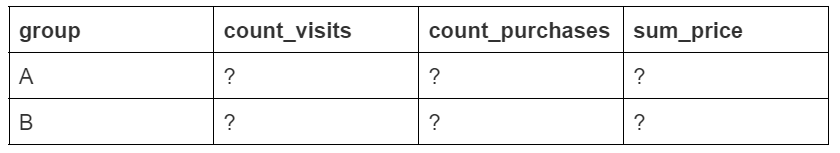

In [9]:
group_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price'})
group_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### **Выводы:** Количество посещений обоих вариантов посадочной страницы сопоставимы. Можно говорить о сбалансированности выборок.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
group_data['conversion']=round(group_data['count_purchases']/group_data['count_visits']*100,2)
group_data['mean_check']=round(group_data['sum_price']/group_data['count_purchases'])
group_data


,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

### **Выводы:** На глаз можно говорить, что несмотря на меньшее количество визитов в группе А, количество фактов покупок выше, т.е. конверсия больше. В группе В конверсия ниже, но прибыль этот вариант приносит больше, средний чек гораздо выше, чем у покупателей группы А.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
group_data = updated_data.groupby(['group','price']).agg({
    'purchase':'count'
}).reset_index()
group_data= group_data[group_data['price'] != 0]
pivot = group_data.pivot_table(
    values='purchase',
    columns='price',
    index='group',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

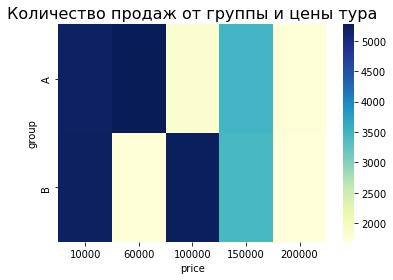

In [12]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Количество продаж от группы и цены тура', fontsize=16);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### **Выводы:** Видим, что на Мальдивы заказов туров почти нет, на Камчатку их мало, а дешевых в Санкт-Петербург наоборот много в обеих группах. Группы отличаются турами в Турцию и Таиланд, группа А предпочитает более дешевые туры в Турцию, а группа В - более дорогие в Таиланд.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
group_data = updated_data.groupby(['group','date']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index().rename(
        columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price'})
group_data['conversion']=round(group_data['count_purchases']/group_data['count_visits']*100,2)
group_data['mean_check']=round(group_data['sum_price']/group_data['count_purchases'])


### **Ответ:**

In [16]:
group_data[group_data['date']=='2021-01-03']

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [ ]:
def cum_summ(x_data):
    x_data.loc[:, 'cum_count_visits'] = x_data['count_visits'].cumsum()
    x_data.loc[:, 'cum_count_purchases'] = x_data['count_purchases'].cumsum()
    x_data.loc[:, 'cum_sum_price'] = x_data['sum_price'].cumsum()
    x_data.loc[:, 'cum_conversion']=x_data['cum_count_purchases']/x_data['cum_count_visits']
    x_data.loc[:, 'cum_mean']=x_data['cum_sum_price']/x_data['cum_count_purchases']
    return x_data

data_a = cum_summ(group_data[group_data['group'] == 'A'])
data_b = cum_summ(group_data[group_data['group'] == 'B'])

print(round(data_b[data_b['date']=='2021-01-20']['cum_conversion']*100,2))
print(round(data_a[data_a['date']=='2021-01-12']['cum_mean']))


### **Ответ:**      

 ###            Кумулятивная конверсия в группе B на 20 января 2021 года   = 11.9%
 ###            Кумулятивный средний чек в группе А на 12 января 2021 года = 81492.0

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

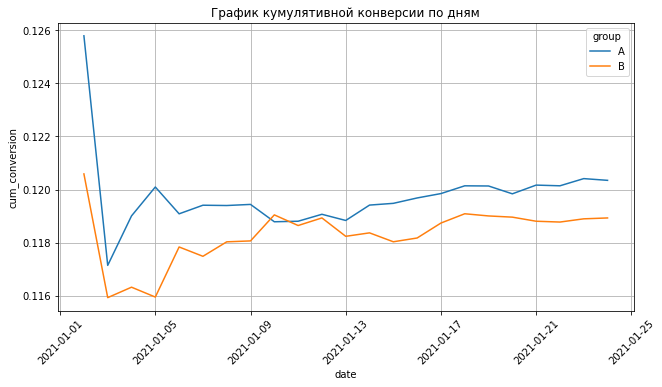

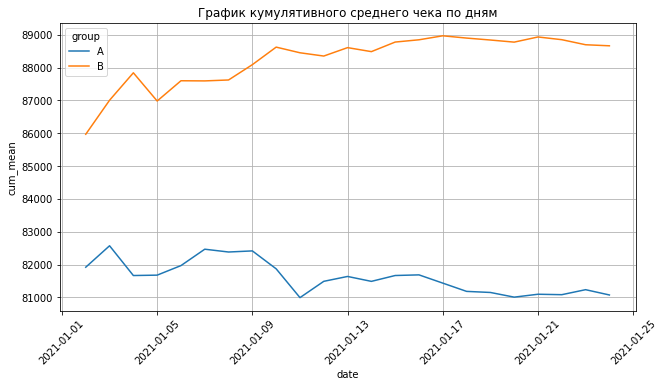

In [18]:
data_conv=pd.concat([data_a, data_b],ignore_index=True)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=data_conv, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean', data=data_conv, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);


### По графику куммулятивной конверсии видимо, что вначале данные "скачут", затем выпрямляются в одну линию, стабилизируются. Конверсия группы B стабильно хуже конверсии группы А почти на всём промежутке времени. 

### Графики куммулятивного среднего чека также сначала проявляют нестабильность, но с набором данных они стабилизируются и выходят к прямой линии. Видно, что значение среднего чека группы В на всем протяжении времени выше значения среднего чека группы А. 

### Выводы "на глазок" подтверждены математически. Тест А/В можно назвать завершенным.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [19]:
converted_piv= data_conv.groupby('group')['cum_conversion'].agg(['sum', 'count'])
display(converted_piv)

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B.'
alpha = 0.05 
a, p_value = proportions_ztest(count=converted_piv['sum'],nobs=converted_piv['count'],alternative='larger')
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,2.754443,23
B,2.720820,23


p-value:  0.49
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### **Выводы:** Мы получили значение p больше заданного a=0.05, согласно условию задани. Значит мы должны принять нулевую гипотезу о равенстве конверсий. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [20]:
data_a = updated_data[updated_data['group'] == 'A']
data_b = updated_data[updated_data['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(n=data_a['user_id'].count(), x_p=data_a['purchase'].mean())
conf_interval_b = proportions_conf_interval(n=data_b['user_id'].count(), x_p=data_b['purchase'].mean()) 

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [data_a['user_id'].count(), data_b['user_id'].count()]
xp = [data_a['purchase'].mean(), data_b['purchase'].mean()]
diff_inverval = diff_proportions_conf_interval(n, xp)

print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### **Выводы:** С надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.21 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %. Интервалы фактически перекрываются.

### Как видно, разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %, т.е. разница может быть как положительной, так и отрицательной. Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Применим тест Шапиро-Уилка для выборок. Возьмем в качестве гипотез следующие формулировки:

    * Нулевая        'Распределения в обеих группах нормальные'
    * Альтернативная 'Распределение в одной или обеих группах отлично от нормального'

In [21]:
last_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price'})
last_data['mean_check']=last_data['sum_price']/last_data['count_purchases']

data_conv_a = last_data[data_conv['group'] == 'A']
data_conv_b = last_data[data_conv['group'] == 'B']

H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data_conv_a['mean_check'])
shapiro_result_b = shapiro(data_conv_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.66
p-value группы B 0.43
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


### **Ответ:** Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [22]:

# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости

results = ttest_ind(
    a=data_conv_a['mean_check'],
    b=data_conv_b['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.5
Принимаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### **Выводы:** Нулевая гипотеза подтвердилась. Ежедневные средние чеки в группах А и B равны

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [23]:
last_data = updated_data.groupby(['group','date']).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()
last_data['mean_check'] = last_data['price'] / last_data['purchase']

data_a = last_data[last_data['group'] == 'A']
data_b = last_data[last_data['group'] == 'B']

def mean_conf_interval(lst=[], gamma=0.95):
    n = len(lst) 
    k = n - 1 
    alpha = 1 - gamma 
    t_crit = -t.ppf(alpha/2, k) 
    x_mean = mean(lst) 
    x_std = stdev(lst)
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

mean_conf_interval(data_a['mean_check'])
mean_conf_interval(data_b['mean_check'])



Доверительный интервал: (79630, 82308)
Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### **Выводы:** Пересечения доверительных интервалов нет. Очевидно, в группе В средний чек выше, что снова подтверждает графические выводы в задании 7.9.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

### При одинаковой конверсии значение среднего чека выше в варианте В. Компании выгоднее использовать вариант В для продажи туров.